In [15]:
import numpy as np
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import importlib
import numpy as np
from jax import grad, jit, vmap
from jax.experimental.ode import odeint
from IPython.display import HTML
from time import time

from typing import TYPE_CHECKING, Callable, Union, Optional

from VariablesClass import VariablesClass
from StructureClass import  StructureClass
from StateClass import StateClass
from EquilibriumClass import EquilibriumClass

import plot_funcs, colors, dynamics, helpers_builders, learning_funcs, file_funcs, numerical_experiments

In [16]:
colors_lst, red, custom_cmap = colors.color_scheme()
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', colors_lst)

## Params

In [17]:
# --- Structure and init params ---

H, S = 5, 1  # # Hinges, # Shims per hinge

Nin = 3  # tip position in (x, y) and its angle
Nout = 3  # Fx, Fy, torque, all on tip

buckle  = jnp.ones((H, S), dtype=jnp.int32)  # initial cubkle state, per shim
# rows = jnp.array([1, 2, 3])
# cols = jnp.array([0])     # for example, first shim of each row
# buckle = buckle.at[rows, cols].set(-1)

k_type = 'Experimental'
# k_type = 'Numerical'

if k_type == 'Experimental':
    L = 0.045  # ~45mm
    translate_ratio = 1
    # L = 1  # keeping it fake bro, otherwise forces explode
    # translate_ratio = 0.045/L
else:
    L = 1
    translate_ratio=1/L

In [18]:
# --- training params --- 

# T_training = 116  # total training set time (not time to reach equilibrium during every step)
T_training = 10

alpha = 20.0  # learning rate

# desired_buckle_type = 'random'
# desired_buckle_rand_key = 169
desired_buckle_type = 'opposite'
# desired_buckle_type = 'straight'

# control also tip angle - True, else False
control_tip_angle = True
# control_tip_angle = False

# if True, fix nodes (0, 1) to zero. if Flase, just the first
# control_first_edge = False
control_first_edge = True

# tip values to buckle shims - 'BEASTAL' for the BEASTAL scheme, else 'one_to_one'
update_scheme = 'one_to_one'  # direct normalized loss, equal to num of outputs
# update_scheme = 'BEASTAL'  # update using the BEASTAL scheme (with pseudoinverse of the incidence matrix).
# update_scheme = 'BEASTAL_no_pinv'  # update using (y_j)(Loss_j), no psuedo inv of the incidence matrix.

# dataset_sampling = 'uniform'  # random uniform vals for x, y, angle
dataset_sampling = 'almost flat'  # flat piece, single measurement
# dataset_sampling = 'stress strain'

# loss_type = 'cartesian'
loss_type = 'Fx_and_tip_torque'

if dataset_sampling == 'stress strain':
    exp_start = 180*1e-3/translate_ratio*(0.99)
    distance = 140*1e-3/translate_ratio
#     exp_start = 4*L - 0.1
#     distance = 2*L
else: 
    exp_start = None
    distance = None

In [19]:
# --- k params ---

if k_type == 'Numerical':
    k_soft_uniform = 1.0
    k_stiff_uniform = 1.5
    thetas_ss_uniform = 1/2
    thresh_uniform = 1

In [20]:
# --- Equilibrium params ---

# k_stretch_ratio = 100/L
k_stretch_ratio = 2e4
k_stretch_increase = 1.0
T_eq= 0.04  # time for equilibrium claculation, [s]
T_eq_decay = 1.0
Eq_iterations = 7
damping = 4.0  # something*sqrt(k*m)
damping_increase = 1.0
mass = 5e-3 # [kg]
tolerance = 1e-8
tolerance_decrease = 1.0
calc_through_energy = False

In [21]:
# --- automatic parameters / variables ---
if k_type == 'Numerical':
    k_soft  = jnp.ones((H, S), dtype=jnp.float32) * k_soft_uniform  # (Hinges, Shims) stiff. in soft direction, per shim
    k_stiff = jnp.ones((H, S), dtype=jnp.float32) * k_stiff_uniform  # (Hinges, Shims) stiff. in stiff direction, per shim
    thetas_ss = jnp.full((H, S), thetas_ss_uniform, dtype=jnp.float32)  # (Hinges, Shims) rest angles per shim
    thresh = jnp.full((H, S), thresh_uniform, dtype=jnp.float32)  # (Hinges, Shims) rest angles per shim
    file_name = None
else:
    k_soft  = None
    k_stiff = None
    thetas_ss = jnp.full((H, S), 1.03312, dtype=jnp.float32)  # (Hinges, Shims) rest angles per shim
    thresh = jnp.full((H, S), 1.96257, dtype=jnp.float32)  # (Hinges, Shims) rest angles per shim
    file_name = 'Roee_offset3mm_dl75.txt'

if desired_buckle_type == 'random':
    key = jax.random.PRNGKey(desired_buckle_rand_key)   # seed
    desired_buckle = jax.random.randint(key, (H, S), minval=-1, maxval=2)  # note: maxval is exclusive
    desired_buckle = desired_buckle.at[desired_buckle==0].set(-1)
elif desired_buckle_type == 'opposite':
    desired_buckle = -buckle
elif desired_buckle_type == 'straight':
    desired_buckle = buckle

In [22]:
desired_buckle

Array([[-1],
       [-1],
       [-1],
       [-1],
       [-1]], dtype=int32)

In [23]:
import StructureClass
importlib.reload(StructureClass)
from StructureClass import StructureClass

# --- build geometry (all topology stays in StructureClass) ---
Strctr = StructureClass(H, S, L, update_scheme=update_scheme, Nin=Nin, Nout=Nout)

C:\Users\roiee\AppData\Local\Temp\ipykernel_27868\404460295.py:6: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  Strctr = StructureClass(H, S, L, update_scheme=update_scheme, Nin=Nin, Nout=Nout)


In [24]:
import VariablesClass
importlib.reload(VariablesClass)
from VariablesClass import VariablesClass

# --- Initiate variables ---
Variabs = VariablesClass(Strctr,
                         k_type=k_type,
                         k_soft=k_soft,
                         k_stiff=k_stiff,
                         thetas_ss=thetas_ss,           # rest/target angles
                         thresh=thresh,                 # threshold to buckle shims
                         stretch_scale=k_stretch_ratio,            # k_stretch = 50 * max(k_stiff)
                         file_name = file_name
                         )

C:\Users\roiee\AppData\Local\Temp\ipykernel_27868\3946770718.py:6: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  Variabs = VariablesClass(Strctr,


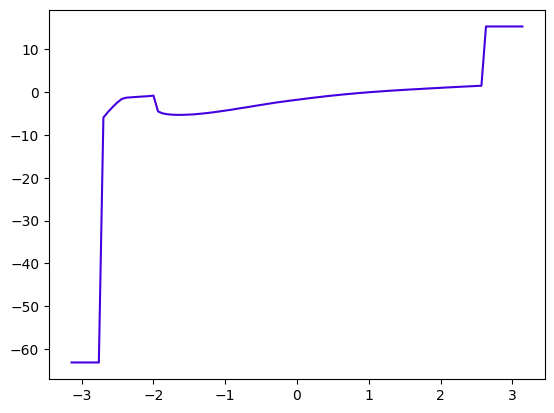

In [25]:
thetas = np.linspace(-np.pi, np.pi, 100)
taus = Variabs.torque(thetas)
plt.plot(thetas, taus)

In [26]:
import SupervisorClass
importlib.reload(SupervisorClass)
from SupervisorClass import SupervisorClass

# --- Initiate Supervisor sizes ---
Sprvsr = SupervisorClass(Strctr, alpha, T_training, desired_buckle, control_tip_angle=control_tip_angle,
                         control_first_edge = control_first_edge, update_scheme=update_scheme, loss_type=loss_type)
print('desired_tau_in_t after init ', Sprvsr.desired_tau_in_t)
Sprvsr.create_dataset(Strctr, sampling=dataset_sampling, 
    exp_start = exp_start,
    distance = distance)
print('tip positions=', Sprvsr.tip_pos_in_t)
# print('desired buckle=', Sprvsr.desired_buckle_arr)

desired_tau_in_t after init  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tip positions= [[0.2655 0.    ]
 [0.2655 0.    ]
 [0.2655 0.    ]
 [0.2655 0.    ]
 [0.2655 0.    ]
 [0.2655 0.    ]
 [0.2655 0.    ]
 [0.2655 0.    ]
 [0.2655 0.    ]
 [0.2655 0.    ]]


## Training

pre training configuration


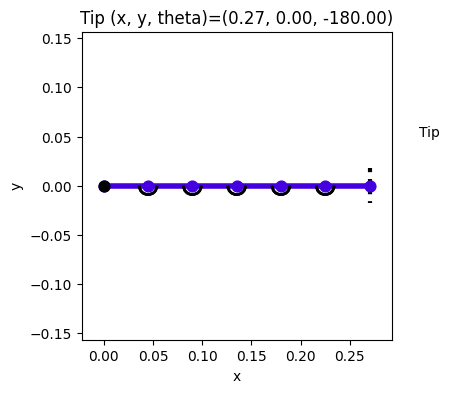

In [27]:
import StateClass
importlib.reload(StateClass)
from StateClass import StateClass
importlib.reload(plot_funcs)

# --- state (straight chain, unit spacing => rest lengths = 1) ---
State_meas = StateClass(Variabs, Strctr, Sprvsr, buckle_arr = buckle)  # buckle defaults to +1
State_update = StateClass(Variabs, Strctr, Sprvsr, buckle_arr = buckle)  # buckle defaults to +1
State_des = StateClass(Variabs, Strctr, Sprvsr, buckle_arr = Sprvsr.desired_buckle_arr)  # buckle defaults to +1

# --- initialize, no tip movement yet
Eq_meas = EquilibriumClass(Strctr, T_eq, damping, mass, tolerance, buckle_arr=State_meas.buckle_arr,
                           pos_arr=State_meas.pos_arr)
Eq_des = EquilibriumClass(Strctr, T_eq, damping, mass, tolerance, buckle_arr=Sprvsr.desired_buckle_arr,
                           pos_arr=State_des.pos_arr)
State_meas._save_data(0, Strctr, State_meas.pos_arr, State_meas.buckle_arr, compute_thetas_if_missing=True,
                      control_tip_angle = control_tip_angle)
State_des._save_data(0, Strctr, State_des.pos_arr, State_des.buckle_arr, compute_thetas_if_missing=True,
                      control_tip_angle = control_tip_angle)  

print('pre training configuration')
plot_funcs.plot_arm(State_meas.pos_arr , State_meas.buckle_arr, State_meas.theta_arr, Strctr.L, modality="measurement")

In [ ]:
importlib.reload(plot_funcs)

pos_noise = Strctr.L * 0.2
vel_noise = 1.5 * 0.01  # from equating 1/2mv^2 = mean(Torque)*L

for t in range(Sprvsr.T):
    print('t=', t)   
    
    ## MEASUREMENT
    print('===MEAUREMENT===')
    
    tip_pos = Sprvsr.tip_pos_in_t[t]
    tip_angle = Sprvsr.tip_angle_in_t[t]    
    print('tip_pos=', tip_pos)
    print('tip_angle=', tip_angle)
    
    # --- equilibrium - measured & desired---
    final_pos, pos_in_t, _, F_theta = Eq_meas.calculate_state(Variabs, Strctr, tip_pos=tip_pos, tip_angle=tip_angle,
                                                              pos_noise=pos_noise, vel_noise=vel_noise)
    
    final_pos_des, _, _, F_theta_des = Eq_des.calculate_state(Variabs, Strctr, tip_pos=tip_pos, tip_angle=tip_angle,
                                                              pos_noise=pos_noise, vel_noise=vel_noise)
#     edge_lengths = vmap(lambda e: Strctr._get_edge_length(final_pos, e))(jnp.arange(Strctr.edges))
#     print('edge lengths', helpers_builders.numpify(edge_lengths))

    # --- save sizes and plot - measured & desired ---
    State_meas._save_data(t, Strctr, final_pos, State_meas.buckle_arr, F_theta, compute_thetas_if_missing=True,
                          control_tip_angle = control_tip_angle)
    State_des._save_data(t, Strctr, final_pos_des, State_des.buckle_arr, F_theta_des, compute_thetas_if_missing=True,
                          control_tip_angle = control_tip_angle)
    Sprvsr.set_desired(final_pos_des, State_des.Fx, State_des.Fy, t, tau=State_des.tip_torque)
    plot_funcs.plot_arm(final_pos, State_meas.buckle_arr, State_meas.theta_arr, Strctr.L, modality = "measurement")
    print('potential F sum', F_theta)
    plot_funcs.plot_arm(final_pos_des, State_des.buckle_arr, State_des.theta_arr, Strctr.L, modality = "measurement")
    print('potential F summed desired', F_theta_des)
    # print('Forces', potential_force_in_t[-1])
    print('Fx on tip, measurement', State_meas.Fx)
    print('Fx on tip, desired', State_des.Fx)
    print('Fy on tip, measurement', State_meas.Fy)
    print('Fy on tip, desired', State_des.Fy)
#     plt.plot(potential_force_in_t[-1,:], '.')
#     plt.show()
    print('torque on tip, measurement', State_meas.tip_torque)
    print('torque on tip, desired', State_des.tip_torque)
    
    # --- loss ---    
    Sprvsr.calc_loss(t, State_meas.Fx, State_meas.Fy, tau=State_meas.tip_torque)
    print('loss', Sprvsr.loss)
    
    ## UPDATE
    print('===UPDATE===')
    
    if t == 0:
        Sprvsr.calc_update_tip(t, Strctr, Variabs, State_meas, current_tip_pos = Sprvsr.tip_pos_in_t[t],
                               current_tip_angle = Sprvsr.tip_angle_in_t[t],
                               prev_tip_update_pos = np.array([Strctr.L*Strctr.edges, 0.0]), prev_tip_update_angle = 0.0)
    else:
        Sprvsr.calc_update_tip(t, Strctr, Variabs, State_meas, current_tip_pos = Sprvsr.tip_pos_in_t[t],
                               current_tip_angle = Sprvsr.tip_angle_in_t[t])
    print('update_tip', Sprvsr.tip_pos_update_in_t[t])
    print('update angle', Sprvsr.tip_angle_update_in_t[t])
    
    # --- equilibrium ---
    final_pos, _, _, F_theta = Eq_meas.calculate_state(Variabs, Strctr, tip_pos=Sprvsr.tip_pos_update_in_t[t],
                                                                    tip_angle=Sprvsr.tip_angle_update_in_t[t],
                                                                    pos_noise=pos_noise, vel_noise=vel_noise)

    # --- save sizes and plot ---
    State_update._save_data(t, Strctr, final_pos, State_update.buckle_arr, F_theta,
                            compute_thetas_if_missing=True, control_tip_angle = control_tip_angle)
    plot_funcs.plot_arm(final_pos, State_update.buckle_arr, State_update.theta_arr, Strctr.L, modality = "update")
    print('pre buckle', State_update.buckle_arr.T)
    # print('energy', Eq.energy(Variabs, Strctr, final_pos)[-1])
    
    # --- shims buckle ---
    State_update.buckle(Variabs, Strctr, t, State_measured = State_meas)      
#     Eq = EquilibriumClass(Strctr, T_eq, damping, mass, buckle_arr=helpers_builders.jaxify(State_update.buckle_arr),
#                           pos_arr=helpers_builders.jaxify(State_update.pos_arr))
    print('post buckle', State_update.buckle_arr.T)
    # print('post buckle update', State_update.buckle_arr)
    # print('energy', Eq.energy(Variabs, Strctr, final_pos)[-1])
    plot_funcs.plot_arm(final_pos, State_update.buckle_arr, State_update.theta_arr, Strctr.L, modality = "update")  
    
    

In [28]:
State_meas.pos_arr

array([[0.        , 0.        ],
       [0.045     , 0.        ],
       [0.09      , 0.        ],
       [0.135     , 0.        ],
       [0.18      , 0.        ],
       [0.22500001, 0.        ],
       [0.27      , 0.        ]], dtype=float32)

In [ ]:
t=0
before_lst_node - scnd_node

In [ ]:
Sprvsr.tip_pos_update_in_t[t, :] = np.array([0.26978707, -0.00021292479])
before_lst_node = np.array([Sprvsr.tip_pos_update_in_t[t, 0] - Strctr.L*np.cos(Sprvsr.tip_angle_update_in_t[t]),
                            Sprvsr.tip_pos_update_in_t[t, 1] - Strctr.L*np.sin(Sprvsr.tip_angle_update_in_t[t])])
print(before_lst_node)
scnd_node = np.array([Strctr.L, 0])
actual_stretch = np.sqrt(np.sum((before_lst_node - scnd_node)**2))
maximal_stretch = ((Strctr.hinges-2)*Strctr.L)
cond = actual_stretch > maximal_stretch
print(cond)
ratio = maximal_stretch / actual_stretch
print((before_lst_node - scnd_node) * ratio)
print((before_lst_node - scnd_node) * ratio + (scnd_node + Sprvsr.tip_pos_update_in_t[t, :] - before_lst_node))


In [ ]:
theta_tot = np.arctan(tip_pos[1]/tip_pos[0])
R = np.sqrt(tip_pos[1]**2 + tip_pos[0]**2)
radial_force = State_meas.Fx*tip_pos[0]/R + State_meas.Fy*tip_pos[1]/R
torque_force = State_meas.Fy*tip_pos[0]/R - State_meas.Fx*tip_pos[1]/R
print('radial_force', radial_force)
print('torque_force', torque_force)

In [ ]:
## Visualize loss and buckle in time

print(np.array([Sprvsr.desired_tau_in_t[t]-State_meas.tip_torque]))

plt.figure()
plt.plot(np.sum(np.abs(Sprvsr.loss_in_t**2), axis=1))
plt.xlabel('t')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.plot(State_update.buckle_in_t[0,0,:])
plt.plot(State_update.buckle_in_t[1,0,:])
plt.plot(State_update.buckle_in_t[2,0,:])
plt.plot(State_update.buckle_in_t[3,0,:])
plt.plot(State_update.buckle_in_t[4,0,:])
plt.xlabel('t')
plt.ylabel('buckle')
plt.legend(['hinge 1', 'hinge 2', 'hinge 3', 'hinge 4', 'hinge 5'])
plt.show()

In [ ]:
## just to break the run

import sys
sys.exit("program complete, Exiting kernel.")

## One shot - compress to tip position from flat configuration

In [ ]:
# importlib.reload(numerical_experiments)

# import EquilibriumClass
# importlib.reload(EquilibriumClass)
# from EquilibriumClass import EquilibriumClass

# # initial tip position
# tip_pos_i = np.array([Strctr.edges*Strctr.L, 0])  # x=L, y=0
# tip_angle_i = 0  # angle=0

# a=0.04
# b=20/100

# # final tip position
# tip_pos_f = np.array([Strctr.edges*Strctr.L*(1-1.5*a), Strctr.L*(40.0*a)])
# print('tip_pos_f=', tip_pos_f)
# tip_angle_f = np.pi*b

# # perform experiment
# State, pos_in_t, force_in_t = numerical_experiments.compress_to_tip_pos(Strctr, Variabs, Sprvsr, tip_pos_i, tip_angle_i,
#                                                                         tip_pos_f, tip_angle_f, Eq_iterations, T_eq, 
#                                                                         damping, mass, tolerance, buckle)

In [ ]:
importlib.reload(plot_funcs)

# animation
fig, anim = plot_funcs.animate_arm(pos_in_t, Strctr.L, interval_ms=100, save_path=f"arm_animation_t{0}.gif", fps=2,
                                   frames=30)

# Show inline animation (uses JavaScript/HTML5)
HTML(anim.to_jshtml())

## ADMET stress strain comparison

In [ ]:
import StateClass
importlib.reload(StateClass)
from StateClass import StateClass

# --- vanilla state --- 

State = StateClass(Variabs, Strctr, Sprvsr, buckle_arr=buckle)

# --- state (straight chain, unit spacing => rest lengths = L) ---
State_meas = StateClass(Variabs, Strctr, Sprvsr, buckle_arr = buckle)  # measurement state, buckle defaults to +1
State_des = StateClass(Variabs, Strctr, Sprvsr, buckle_arr = buckle)  # desired states a.f.o training set

In [ ]:
importlib.reload(numerical_experiments)
importlib.reload(plot_funcs)

tip_angle = +0.0
plot_every = 4
pos_noise = Strctr.L * 0.1
vel_noise = 1.5 * 0.01  # from equating 1/2mv^2 = mean(Torque)*L

Fx_afo_pos, pos_frames, buckle_frames, theta_frames = numerical_experiments.ADMET_stress_strain(Strctr, Variabs, Sprvsr,
                                                                                                State,  T_eq, damping, mass,
                                                                                                tolerance, tip_angle,
                                                                                                pos_noise=pos_noise,
                                                                                                vel_noise=vel_noise)

In [ ]:
importlib.reload(plot_funcs)

# animation
fig, anim = plot_funcs.animate_arm(pos_frames, Strctr.L, interval_ms=100, save_path=f"arm_animation_t{0}.gif", fps=2,
                                   frames=50)

# Show inline animation (uses JavaScript/HTML5)
HTML(anim.to_jshtml())

# Call the save method with a .gif extension
anim.save('buckle[11111]bellyUp.gif', writer='pillow')

In [ ]:
## --- Save csv file ---

file_funcs.export_stress_strain_sim(Sprvsr, Fx_afo_pos/1000, L, State_des.buckle_arr, filename="L=1_buckle[1 1 1 1 1] belly up.csv")

In [ ]:
## --- import CSVs and plot ---

importlib.reload(file_funcs)
importlib.reload(plot_funcs)

# exp_path = "Experimental ADMET Bi-ax\\Oct4\\leave_every_time\\Roee_buckle11111_bellyDown.csv"
# exp_path = "Experimental ADMET Bi-ax\\Oct3\\Roee_buckle11111_init190mm_inside150mm_bellyDown.csv"
# exp_path = "Experimental ADMET Bi-ax\\Oct5\\BellyUp_2ndshims_1stattempt.csv"

## buckle [1 1 1 1 1] Oct 5

## belly down
# exp_path_1 = "Experimental ADMET Bi-ax\\Oct5\\bellyDown_1stshims_1stattempt.csv"
# exp_path_2 = "Experimental ADMET Bi-ax\\Oct5\\bellyDown_2ndshims_1stattempt.csv"
# exp_path_3 = "Experimental ADMET Bi-ax\\Oct5\\bellyDown_1stshims_2ndattempt.csv"
# exp_df_1 = file_funcs.import_stress_strain_exp_and_plot(exp_path_1, plot=False)
# exp_df_2 = file_funcs.import_stress_strain_exp_and_plot(exp_path_2, plot=False)
# exp_df_3 = file_funcs.import_stress_strain_exp_and_plot(exp_path_3, plot=False)
# exp_dfs = [exp_df_1, exp_df_2, exp_df_3]
# sim_path = "L=1_buckle[1 1 1 1 1] belly down.csv"
# sim_df = file_funcs.import_stress_strain_sim_and_plot(sim_path, plot=False)

## belly up
exp_path_1 =  "Experimental ADMET Bi-ax\\Oct5\\BellyUp_1stshims.csv"
exp_path_2 =  "Experimental ADMET Bi-ax\\Oct5\\BellyUp_2ndshims_1stattempt.csv"
exp_df_1 = file_funcs.import_stress_strain_exp_and_plot(exp_path_1, plot=False)
exp_df_2 = file_funcs.import_stress_strain_exp_and_plot(exp_path_2, plot=False)
exp_dfs = [exp_df_1, exp_df_2]
# sim_path = "Simulation stress strain\\Nov17\\L=1_buckle[1 1 1 1 1] belly up.csv"
sim_path = "L=1_buckle[1 1 1 1 1] belly up.csv"
sim_df = file_funcs.import_stress_strain_sim_and_plot(sim_path, plot=False)

## buckle [1 0 0 0 1] Oct 4
# exp_path_1 = "Experimental ADMET Bi-ax\\Oct4\\dismantle_every_time\\Roee_buckle10001_bellyUp_level_1st.csv"
# exp_path_2 = "Experimental ADMET Bi-ax\\Oct4\\dismantle_every_time\\Roee_buckle10001_bellyUp_level_2nd.csv"
# exp_path_3 = "Experimental ADMET Bi-ax\\Oct4\\dismantle_every_time\\Roee_buckle10001_bellyUp_level_3rd.csv"
# exp_df_1 = file_funcs.import_stress_strain_exp_and_plot(exp_path_1, plot=False)
# exp_df_2 = file_funcs.import_stress_strain_exp_and_plot(exp_path_2, plot=False)
# exp_df_3 = file_funcs.import_stress_strain_exp_and_plot(exp_path_3, plot=False)
# exp_dfs = [exp_df_1, exp_df_2, exp_df_3]
# sim_path = "Simulation stress strain\\Nov17\\L=1_buckle[1 0 0 0 1] belly up.csv"
# sim_df = file_funcs.import_stress_strain_sim_and_plot(sim_path, plot=False)


plot_funcs.plot_compare_sim_exp_stress_strain(exp_dfs, sim_df, 1000)

## SIngle hinge stress strain

In [ ]:
# skip = 8

# if k_type == 'Experimental':
#     thetas, torques, ks, torque_of_theta, k_of_theta = file_funcs.build_torque_stiffness_from_file(file_name, savgol_window=9)
#     thetas = np.concatenate((thetas[::-skip], thetas[::skip]))
#     torques = np.concatenate((torques[::-skip], -torques[::-skip]))
#     ks = np.concatenate((ks[::-skip], ks[::skip]))
# elif k_type == 'Numerical':
#     # thetas = np.concatenate((np.arange(-np.pi/2, np.pi/2, np.pi/(T_training/2)), -np.arange(-np.pi/2, np.pi/2, np.pi/(T_training/2))))
#     thetas = np.concatenate((np.arange(-np.pi/2, np.pi/2, np.pi/(T_training/2)), -np.arange(-np.pi/2, np.pi/2, np.pi/(T_training/2))))
#     torques = np.zeros(np.size(thetas))
#     B = -np.ones((Strctr.hinges, Strctr.shims))
#     for i, theta in enumerate(thetas):
#         T = thetas[i, None]                 # (H,1)
#         TH = Variabs.thetas_ss[:, None]     # (H,1) 
#         # spring constant is position dependent
#         stiff_mask = ((B == 1) & (T < TH)) | ((B == -1) & (T > -TH))  # thetas are counter-clockwise    
#         k_rot_state = jnp.where(stiff_mask, Variabs.k_stiff, Variabs.k_soft)  # (H,S)
#         torques[i] = jnp.sum(k_rot_state * (T - B*TH)) 
#         B_nxt = np.zeros((Strctr.hinges, Strctr.shims))
#         for j in range(Strctr.hinges):
#             for l in range(Strctr.shims):
#                 if B[j, l] == 1 and T[j] < -Variabs.thresh[j]:  # buckle up since thetas are CCwise
#                     B_nxt[j, l] = -1
#                     print('buckled up, theta=', T[j])
#                 elif B[j, l] == -1 and T[j] > Variabs.thresh[j]:  # buckle down, thetas are CCwise
#                     B_nxt[j, l] = 1
#                     print('buckled down, theta=', T[j])
#                 else:
#                     B_nxt[j, l] = B[j, l]
#         B = B_nxt
# thetas_degs = np.rad2deg(thetas)

In [ ]:
# plt.plot(thetas, torques)
# plt.show()

In [ ]:
# import EquilibriumClass
# importlib.reload(EquilibriumClass)
# from EquilibriumClass import EquilibriumClass

# torque_sim = np.zeros(np.size(thetas))
# Fx_sim = np.zeros(np.size(thetas))
# Fy_sim = np.zeros(np.size(thetas))
# energy_sim = np.zeros(np.size(thetas))
# for i, theta in enumerate(-thetas):
#     print('theta', np.rad2deg(theta))
#     tip_angle = -np.pi + theta
#     tip_pos = Strctr.L*np.array([1, 0]) + Strctr.L*np.array([np.cos(theta), np.sin(theta)])
#     # print('tip_angle', tip_angle)
#     # print('tip_pos', tip_pos)
    
#     # --- initialize, no tip movement yet
#     if State.pos_arr is not None:  # calculate equilib from state of previous run, if happened
#         Eq = EquilibriumClass(Strctr, T_eq, damping, mass, tolerance, calc_through_energy = calc_through_energy,
#                               buckle_arr=State.buckle_arr, pos_arr=State.pos_arr)
#     else:  # use initial flat position
#         Eq = EquilibriumClass(Strctr, T_eq, damping, mass, tolerance, calc_through_energy = calc_through_energy,
#                               buckle_arr=buckle_arr)
#     final_pos, pos_in_t, vel_in_t, potential_force_in_t = Eq.calculate_state(Variabs, Strctr, tip_pos=tip_pos,
#                                                                              tip_angle=None)
#     theta_from_dynamics = vmap(lambda h: Strctr._get_theta(final_pos, h))(jnp.arange(Strctr.hinges))
#     print('theta_from_dynamics = ', theta_from_dynamics)
#     if k_type == 'Experimental':
#         theta_eff = State.buckle_arr[0] * theta_from_dynamics              # (H,S)
#         k_rot_state = Variabs.k(theta_eff)
#     else:
#         stiff_mask = ((State.buckle_arr[0] == 1) & (theta_from_dynamics < Variabs.thetas_ss)) \
#         | ((State.buckle_arr[0] == -1) & (theta_from_dynamics > -Variabs.thetas_ss))  # thetas are counter-clockwise    
#         k_rot_state = jnp.where(stiff_mask, Variabs.k_stiff, Variabs.k_soft)  # (H,S)
#     print('k=', k_rot_state)
#     print('delta theta=', theta_from_dynamics - State.buckle_arr[0]*Variabs.thetas_ss)
#     State._save_data(i, Strctr, final_pos, State.buckle_arr, Forces=potential_force_in_t, compute_thetas_if_missing=True,
#                      control_tip_angle=control_tip_angle)
#     State.buckle(Variabs, Strctr, i, State_meas)
#     plot_funcs.plot_arm(State.pos_arr , State.buckle_arr, State.theta_arr, Strctr.L, modality="measurement") 
#     torque_sim[i] = helpers_builders.torque(tip_angle, State.Fx, State.Fy)
#     Fx_sim[i] = State.Fx
#     Fy_sim[i] = State.Fy
#     energy_sim[i], _, _ = Eq.energy(Variabs, Strctr, final_pos)
#     print('torque=', State.tip_torque)
#     print('Forces=', potential_force_in_t[-1])
#     print('tip angle=', tip_angle)
    
# plt.plot(thetas, torques, thetas, -torque_sim)

In [ ]:
# plt.plot(thetas, torques)  # experimental
# plt.plot(-thetas[4:-4], -Variabs.k(thetas[4:-4])*(thetas[4:-4]-Variabs.thetas_ss).reshape(-1), '--')  # energy
# plt.plot(thetas[1:], -torque_sim[1:], '--')  # forces directly
# # plt.plot(thetas[1:], torque_from_energy[1:], thetas[1:], torque_sim[1:], '--') 
# plt.xlabel(r'$\theta$')
# plt.ylabel(r'$\tau$')
# # plt.legend(['Experimental', 'Numerical'])
# plt.legend(['experimental', 'jax energy', 'jax forces'])
# plt.ylim([-6, 6])

In [ ]:
# print('theta', thetas[18])
# print('torque at theta', Variabs.torque(thetas[18]))
# print('desire buckle theta', Variabs.thresh)

In [ ]:
# import EquilibriumClass
# importlib.reload(EquilibriumClass)
# from EquilibriumClass import EquilibriumClass

# energies = np.zeros(int(T_eq))
# for i in range(int(T_eq)):
#     energies[i], _, _ = Eq.energy(Variabs, Strctr, pos_in_t[i])
    
# plt.plot(energies)
# plt.yscale('log')

# # energies_nxt, _, _ = Eq.calculate_energy_in_t(Variabs, Strctr, pos_in_t)
# # plt.plot(energies_nxt)
# # plt.yscale('log')

# plot_funcs.plot_arm(State.pos_arr , State.buckle_arr, State.theta_arr, Strctr.L, modality="measurement")

In [ ]:
# import EquilibriumClass
# importlib.reload(EquilibriumClass)
# from EquilibriumClass import EquilibriumClass

# # --- initialize, no tip movement yet
# if State.pos_arr is not None:  # calculate equilib from state of previous run, if happened
#     Eq = EquilibriumClass(Strctr, T_eq, damping, mass, calc_through_energy = calc_through_energy,
#                         buckle_arr=buckle, pos_arr=State.pos_arr)
# else:  # use initial flat position
#     Eq = EquilibriumClass(Strctr, T_eq, damping, mass, calc_through_energy = calc_through_energy,
#                           buckle_arr=buckle)
# final_pos, pos_in_t, vel_in_t, potential_force_in_t = Eq.calculate_state(Variabs, Strctr, tip_pos=tip_pos,
#                                                                          tip_angle=tip_angle)
# State._save_data(0, Strctr, final_pos, State.buckle_arr, potential_force_in_t, compute_thetas_if_missing=True,
#                  control_tip_angle = control_tip_angle)
# print('State_notip buckle', State.buckle_arr)
# plot_funcs.plot_arm(State.pos_arr , State.buckle_arr, State.theta_arr, Strctr.L, modality="measurement")

In [ ]:
fontsize = 16
plt.plot(thetas[1:], torques[1:], '-', thetas[1:], torque_sim[1:], '--', linewidth=3.0)
plt.legend(['experimental', 'numerical'], fontsize=fontsize)
plt.xlabel(r'$\theta\,\left[rad\right]$', fontsize=fontsize)
plt.ylabel(r'$\tau$', fontsize=fontsize)

plt.plot(thetas[1:], energy_sim[1:], '--', linewidth=3.0)
plt.legend(['theoretical', 'numerical'], fontsize=fontsize)
plt.xlabel(r'$\theta\,\left[rad\right]$', fontsize=fontsize)
plt.ylabel(r'$E$', fontsize=fontsize)

plt.plot(thetas[0:], Fx_sim[0:], '-', linewidth=3.0)
plt.legend(['theoretical', 'numerical'], fontsize=fontsize)
plt.xlabel(r'$\theta\,\left[rad\right]$', fontsize=fontsize)
plt.ylabel(r'$Fx$', fontsize=fontsize)

plt.plot(thetas[0:], Fy_sim[0:], '-', linewidth=3.0)
plt.legend(['theoretical', 'numerical'], fontsize=fontsize)
plt.xlabel(r'$\theta\,\left[rad\right]$', fontsize=fontsize)
plt.ylabel(r'$Fy$', fontsize=fontsize)

plt.plot(potential_force_in_t[-18:,::2].T, '.')
plt.ylabel('forces x')
plt.show()
plt.plot(potential_force_in_t[-18:,1::2].T, '.')
plt.ylabel('forces y')
plt.show()

# np.shape(vel_in_t)
plt.plot(vel_in_t[-18:,:,0].T, '.')
plt.ylabel('velocities x')
plt.show()
plt.plot(vel_in_t[-18:,:,1].T, '.')
plt.ylabel('velocities y')
plt.show()

State.buckle_in_t

## Parameter study

In [ ]:
# dist_noise = 0.001
# angle_noise = 1e-2
# tip_pos = Sprvsr.tip_pos_in_t[3]

# k_strtch_vec = [1e2, 2e2, 4e2, 1e3, 2e3, 4e3, 1e4, 2e4, 4e4]
# Fx_afo_pos = np.zeros(len(k_strtch_vec))

# for i, k_stretch_ratio in enumerate(k_strtch_vec):
    
#     print('k_stretch_ratio', k_stretch_ratio)
    
#     # --- Initiate variables ---
#     Variabs = VariablesClass(Strctr,
#                              k_type = k_type,
#                              k_soft=k_soft,
#                              k_stiff=k_stiff,
#                              thetas_ss=thetas_ss,           # rest/target angles
#                              thresh=thresh,                 # threshold to buckle shims
#                              stretch_scale=k_stretch_ratio,            # k_stretch = 50 * max(k_stiff)
#                              file_name = file_name
#                              )
    
#     Sprvsr.create_dataset(Strctr, sampling=dataset_sampling, 
#                           exp_start = exp_start,
#                           distance = distance,
#                           dist_noise = dist_noise,
#                           angle_noise = angle_noise)
    
#     State_des = StateClass(Variabs, Strctr, Sprvsr, buckle_arr = buckle)  # desired states a.f.o training set
    
# #     if i == 0:
# #         Eq_des = EquilibriumClass(Strctr, T_eq, damping, mass, tolerance, buckle_arr=Sprvsr.desired_buckle_arr)
# #     else:
# #         Eq_des = EquilibriumClass(Strctr, T_eq, damping, mass, tolerance, buckle_arr=Sprvsr.desired_buckle_arr,
# #                                   pos_arr=final_pos)
#     Eq_des = EquilibriumClass(Strctr, T_eq, damping, mass, tolerance, buckle_arr=Sprvsr.desired_buckle_arr)
#     final_pos, pos_in_t, vel_in_t, potential_force_in_t = Eq_des.calculate_state(Variabs, Strctr, tip_pos=tip_pos,
#                                                                                  tip_angle=Sprvsr.tip_angle_in_t[i])
    
#     State_des._save_data(i, Strctr, pos_arr=final_pos, buckle_arr=State_des.buckle_arr, Forces=potential_force_in_t,
#                          compute_thetas_if_missing=True, control_tip_angle = control_tip_angle)
#     print('State tip forces ', [State_des.Fx, State_des.Fy])
#     print('edges length', Strctr.all_edge_lengths(State_des.pos_arr))
#     print('stretch energy', Variabs.k_stretch*(Strctr.all_edge_lengths(State_des.pos_arr) - Strctr.rest_lengths)**2)  # stretch energy
#     print('torque energy', Variabs.torque(State_des.theta_arr)*Strctr.L)
#     # print('State tip torque ', State_des.tip_torque)
#     Sprvsr.set_desired(final_pos, State_des.tip_pos[-2], State_des.tip_pos[-1], i, State_des.tip_torque)
#     plot_funcs.plot_arm(State_des.pos_arr , State_des.buckle_arr, State_des.theta_arr, Strctr.L, modality='measurement')
#     plt.plot(potential_force_in_t[-1, ::2], '.')
#     plt.plot(potential_force_in_t[-1, 1::2], '.')
#     plt.show()
    
# #     tot_energies = np.zeros(int(T_eq))
# #     rot_energies = np.zeros(int(T_eq))
# #     strtch_energies = np.zeros(int(T_eq))
# #     for i in range(int(T_eq)):
# #         tot_energies[i], rot_energies[i], strtch_energies[i] = Eq_des.energy(Variabs, Strctr, pos_in_t[i])

# #     plt.plot(tot_energies)
# #     plt.plot(rot_energies)
# #     plt.legend(['tot', 'rot', 'stretch'])
# #     plt.yscale('log')
# #     plt.show()

#     Fx_afo_pos[i] = State_des.Fx
    
# # State_meas._save_data(0, Strctr, State_meas.pos_arr, State_meas.buckle_arr, compute_thetas_if_missing=True,
# #                       control_tip_angle = control_tip_angle)
# # print('pre training configuration')
# # plot_funcs.plot_arm(State_meas.pos_arr , State_meas.buckle_arr, State_meas.theta_arr,Strctr.L, modality='measurement')
# plt.plot(Fx_afo_pos)
# plt.ylabel('Fx')

## Show what is static and what is not

In [ ]:
# import jax
# import jax.numpy as jnp
# import equinox as eqx

# params, static = eqx.partition(Variabs, eqx.is_inexact_array)

# # 1) Quick look: print the leaves that are considered “params”
# print("Param leaves (count):", len(jax.tree_util.tree_leaves(params)))

# # 2) See shapes/dtypes of param leaves
# leaf_summary = jax.tree_util.tree_map(
#     lambda x: (getattr(x, "shape", None), getattr(x, "dtype", None)), params
# )
# print(leaf_summary)

# # 3) If you want a compact structure printout:
# print("PARAM STRUCT:", jax.tree_util.tree_structure(params))
# print("STATIC STRUCT:", jax.tree_util.tree_structure(static))
